# Summary of results

In [19]:
import matplotlib.pyplot  as plt
import load_annotations   as annotate
import parameters
import pipeline
import wfdb

%matplotlib inline

data_path = 'sample_data/challenge_training_data/'
ann_path = 'sample_data/challenge_training_multiann/'
ecg_ann_type = 'gqrs'
data_fs = parameters.DEFAULT_FS

## Overview of algorithm

![title](figures/overview.jpg)

##### Invalid sample detection: 
Valid if passes all tests: 
- Histogram check
- Values within reasonable range
- NaN check
- Not too much noise in range 70-90 Hz

c_val gives ratio of valid data to overall signal (1.0 = completely valid data)

##### Regular activity test: 
Regular activity if passes all tests: 
- Valid data (as given by invalid sample detection tests)
- Standard deviation of RR intervals
- Average HR over entire signal within reasonable limits
- Sum of RR intervals is close enough to entire length of signal
- Number of total RR intervals above threshold

##### Asystole test: 
- Checks if there are any heart beat annotations for a rolling 3.2 sec window in each of the channels, weighted by the validity coefficient cval

##### Bradycardia test: 
- Chooses the "most reliable" channel which passes the sum and count tests with minimum standard deviation
- Finds the mininum heart rate for four consecutive beats, return true alarm if < 45 bpm

##### Tachycardia test: 
- Returns true if mean heart rate for overall signal > 135 bpm (given that the stdev test and sum test pass)
- Chooses the "most reliable" channel and returns true if max heart rate for 12 consecutive beats > 130 bpm

##### Ventricular tachycardia test: 
- ECG channels: 4 consecutive ventricular beats at a heart rate of > 95 bpm
- ABP channel: searches for a 3s window with standard deviation < 6 mmHg
- If local scores weighted by validity score (cval) sum to > 0, return true

##### Ventricular flutter/fibrillation test: 
- Only reject alarm in regular activity test based on ECG channels
- Check maximum duration of low frequency dominance; if > 3 sec, set vector R to 1's
- ABP channel: if stdev in a rolling 2 sec window < 6 mmHg, reinforces likelihood of vfib in that section (add cval to R vector)
- ECG channels: dominant frequencies are calculated, if any part of the signal has irregular activity with a dominant frequency > 2 Hz and R value > 0, return true

## Overall comparison of results

#### Confusion matrix for current algorithm: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 249                         | 95        |
| **False** | <font color='red'>45</font> | 361       |

|           | **True**                        | **False** |        
| ---       | :---:                           | :---:     |
| **True**  | 0.332                           | 0.127     |
| **False** | <font color='red'>0.06</font>   | 0.481     |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 1        | 8         | 2         | 0                | 34        |

#### Confusion matrix for other algorithms: 

##### fplesinger-210: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 275                         | 64        |
| **False** | <font color='red'>19</font> | 392       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 1        | 1         | 1         | 1                | 15        |


##### l.m.eerikainen-209:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 294                         | 65        |
| **False** | <font color='red'>0</font>  | 391       |


##### bellea-212:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 291                         | 327       |
| **False** | <font color='red'>3</font>  | 129       |


| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 3        | 0         | 0         | 0                | 0         |

##### hoog.antink-216:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 291                         | 89        |
| **False** | <font color='red'>3</font>  | 367       |


| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 0         | 0         | 0                | 3         |

##### vxk106120-213:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 280                         | 74        |
| **False** | <font color='red'>14</font> | 382       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 0         | 0         | 0                | 14        |


##### bestcly-204:
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 277                         | 133       |
| **False** | <font color='red'>17</font> | 323       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 3         | 1         | 0                | 13        |


##### sibylle.fallet-210: 
|           | **True**                    | **False** |        
| ---       | :---:                       | :---:     |
| **True**  | 276                         | 108       |
| **False** | <font color='red'>18</font> | 348       |

| **Asys** | **Brady** | **Tachy** | **Vfib/flutter** | **Vtach** |
| :---:    | :---:     | :---:     | :---:            | :---:     |
| 0        | 1         | 4         | 0                | 13        |


## Examples

In [20]:
def classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=False): 
    true_alarm = pipeline.is_true_alarm(data_path, sample_name)
    classified_true_alarm = pipeline.is_classified_true_alarm(data_path, ann_path, sample_name, ecg_ann_type, verbose)
    matrix_classification = pipeline.get_confusion_matrix_classification(true_alarm, classified_true_alarm)

    title = matrix_classification + ": " + sample_name
    plot_signal(data_path, sample_name, title)

    
def plot_signal(data_path, sample_name, plot_title=""): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    fs = fields['fs']
    channels = fields['signame']
    non_resp_channels = [ index for index in range(len(channels)) if channels[index] != "RESP" ]
    alarm_type = fields['comments'][0]
    tested_block_length = parameters.TESTED_BLOCK_LENGTHS[alarm_type]
    
    start_time, end_time = parameters.ALARM_TIME - tested_block_length, parameters.ALARM_TIME
    start, end = int(start_time * fs), int(end_time * fs)
    wfdb.plotwfdb(sig[start:end, non_resp_channels], fields, title=plot_title)
    

### Asystole

#### True positive

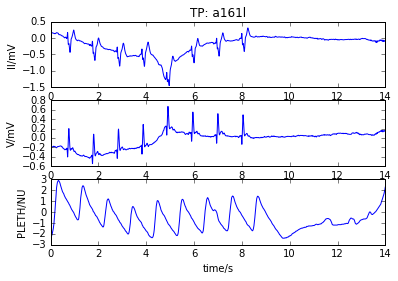

In [21]:
sample_name = "a161l"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type)

#### False negative

No annotations in specified sample range
No annotations in specified sample range


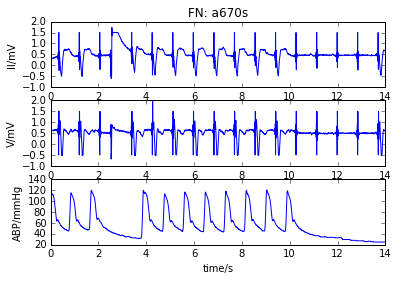

In [22]:
sample_name = "a670s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type)

Annotations indicated for pacemarker artefacts despite not QRS --> asystole not detected because QRS complexes annotated in ECG channels

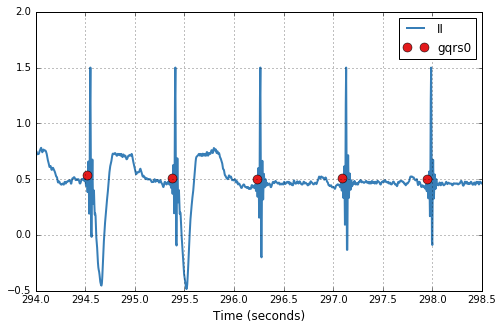

In [23]:
channel_index = 0
start, end = 294, 298.5
annotate.plot_annotations(data_path, ann_path, sample_name, channel_index, start, end, ecg_ann_type, data_fs)

### Bradycardia

All bradycardia samples which were false negatives:
- b183l
- b187l
- b379l
- b494s
- b495l
- b497l
- b672s
- b734s

#### Representative false negative

b497l with min HR: 46.1538461538


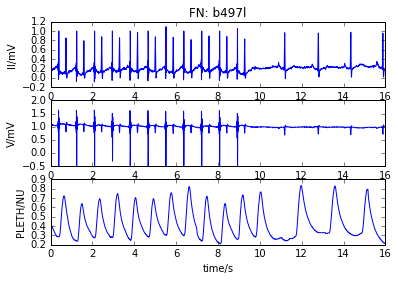

In [24]:
sample_name = "b497l"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

The cutoff HR for bradycardia is 45 bpm. Most of the false negatives have heart rates only slightly greater than the cutoff. 

#### Interesting annotations/signals?

b187l with min HR: 102.915951973


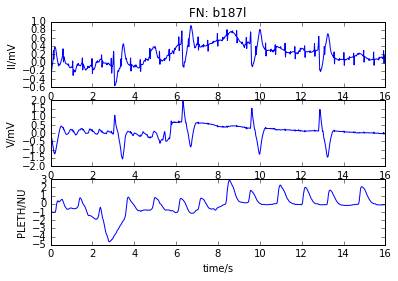

In [25]:
sample_name = "b187l"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

Very different annotations between the different ECG channels. II channel was chosen by the algorithm to find the min HR in determining bradycardia.

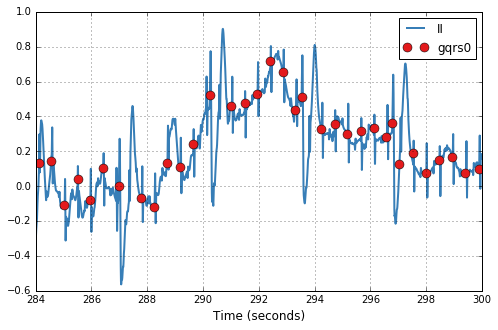

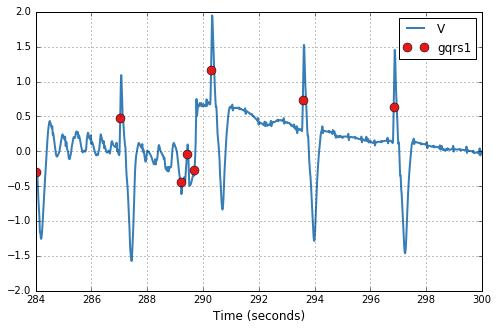

In [26]:
start, end = 284, 300
annotate.plot_annotations(data_path, ann_path, sample_name, 0, start, end, ecg_ann_type, data_fs)
annotate.plot_annotations(data_path, ann_path, sample_name, 1, start, end, ecg_ann_type, data_fs)

Similar issue for "b494s": (channel II was selected as the best channel)

b494s with min HR: 64.1711229947


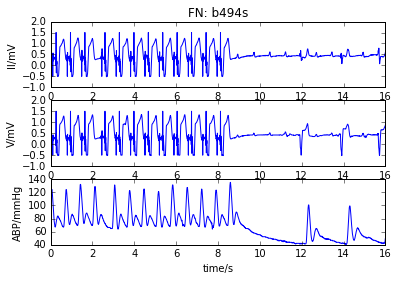

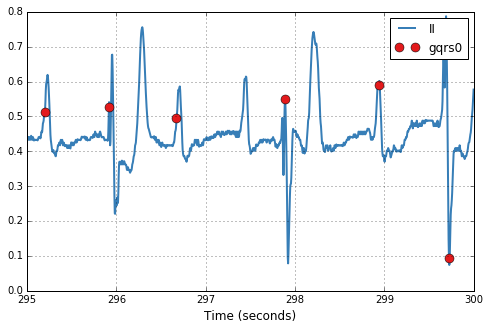

In [27]:
sample_name = "b494s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

start, end = 295, 300
annotate.plot_annotations(data_path, ann_path, sample_name, 0, start, end, ecg_ann_type, data_fs)

### Tachycardia

#### Too few beats before alarm

t418s with max HR: 115.163147793


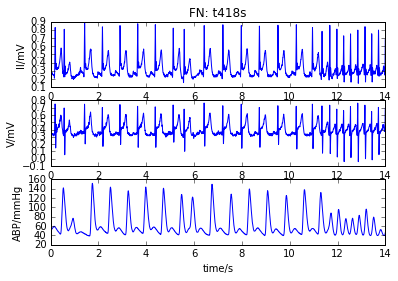

In [28]:
sample_name = "t418s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

II channel was chosen by the algorithm to find the max HR in determining tachycardia. This ECG data segment has a high heart rate for a short period of time at the end of the segment right before the alarm gets triggered. Because a high heart rate is only seen at the end of the segment, the overall HR for a segment of at least 12 beats (as necessitated by the algorithm) is not seen to be higher than the minimum needed to trigger tachycardia.

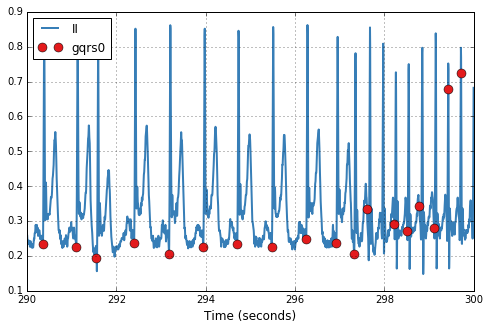

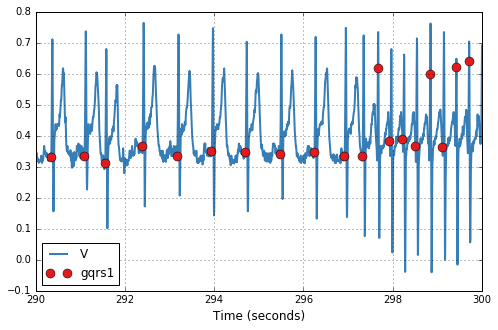

In [29]:
start, end = 290, 300
annotate.plot_annotations(data_path, ann_path, sample_name, 0, start, end, ecg_ann_type, data_fs, loc=2)
annotate.plot_annotations(data_path, ann_path, sample_name, 1, start, end, ecg_ann_type, data_fs, loc=3)

#### Poor selection of best channel

t700s with max HR: 83.9552238806


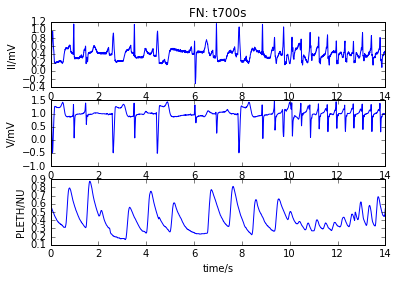

In [30]:
sample_name = "t700s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

II channel is chosen by the algorithm as the channel by which to determine tachycardia, even though the annotations for the second channel (V) is much cleaner. This is because of the criterion used to determine the "best" channel: min standard deviation of all the channels that satisfy the other tests (# of annotations and sum of the annotations > min threshold). This is maybe not the best/most relevant criterion in deciding the best test, and we should likely explore something else to eliminate these false negatives. 

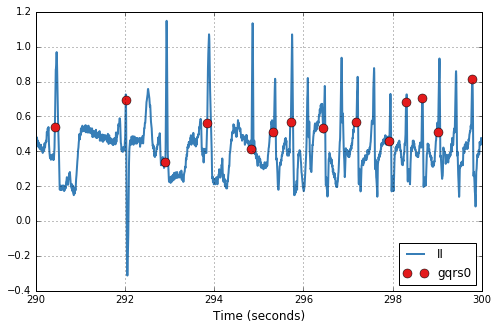

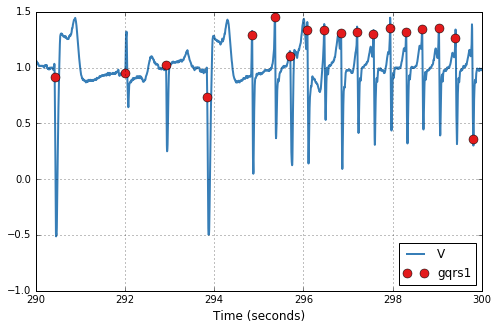

In [31]:
start, end = 290, 300
annotate.plot_annotations(data_path, ann_path, sample_name, 0, start, end, ecg_ann_type, data_fs, loc=4)
annotate.plot_annotations(data_path, ann_path, sample_name, 1, start, end, ecg_ann_type, data_fs, loc=4)

### Ventricular tachycardia

All vtach samples which were false negatives:
- Detected in one channel: v131l, v133l, v139l, v158s, v197l, v348s, v471l (missing annotations), v523l, v525l, v574s, v579l (missing annotations), v597l, v607l (missing annotations), v629l, v636s, v696s, v701l, v724s, v761l (weird MCL channel), v773l, v793l, v797l (missing annotations), v805l, v806s (missing annotations), v813l (missing annotations), v818s (slightly offset annotations)
- Detected in no channels: v206s, v334s, v448s (irregular signal), v728s, v831l, v571l (missing annotations, flutter)
- Vtach?: v206s, v534s
- Detected in both channels: v626s

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


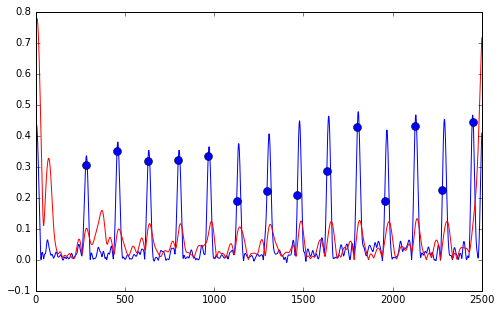

v206s on channel II with max ventricular HR:  0
[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


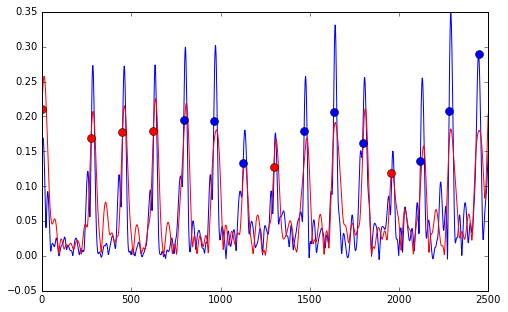

v206s on channel V with max ventricular HR:  72.1153846154


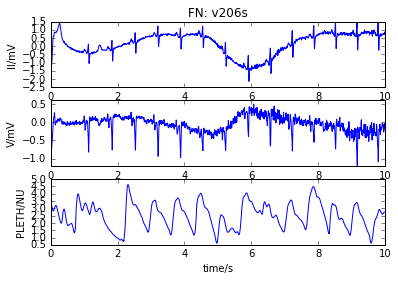

In [32]:
sample_name = "v206s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

#### Detected in one channel

[-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1.] [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1.]


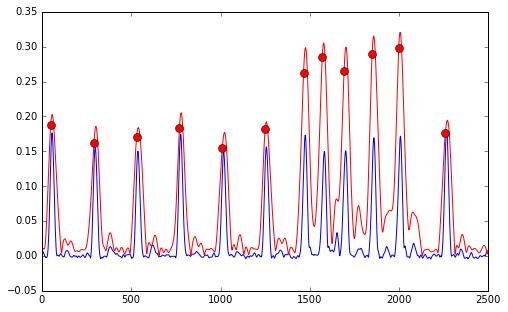

v133l on channel II with max ventricular HR:  117.1875
[-2. -2. -2. -2. -2. -2. -2. -2.  0.  0.  0.  0.  0. -2. -2.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


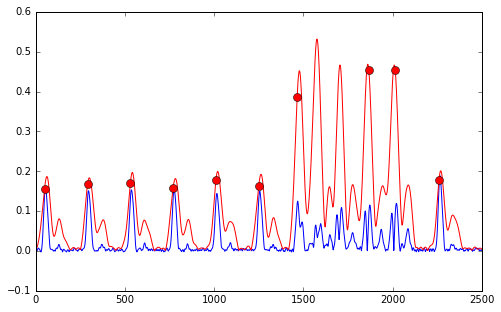

v133l on channel MCL with max ventricular HR:  64.7482014388
[-3. -3. -3. -3. -3. -3. -3. -3. -1. -1. -1. -1. -1. -3. -3.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


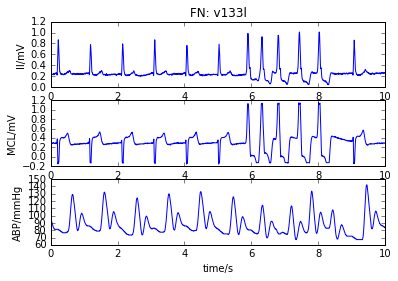

In [33]:
sample_name = "v133l"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

Three things to note here: 
1. Even though a high enough ventricular heart rate is detected on one of the channels, this is canceled out by the other channel so the alarm is flagged as a false alarm. 
2. Many normal beats are incorrectly detected as ventricular beats.
3. Missing annotations of QRS complexes

#### Detected in both channels

No annotations in specified sample range
No annotations in specified sample range
[ 1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] [ 1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


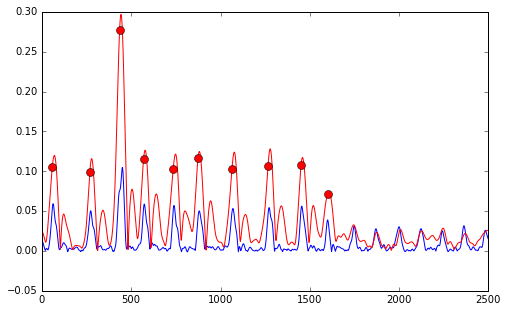

v626s on channel II with max ventricular HR:  102.505694761
[ 0.  0.  0.  0. -2. -2. -2. -2.  0.  0.  0.  0.  0.  0.  0.] [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.]


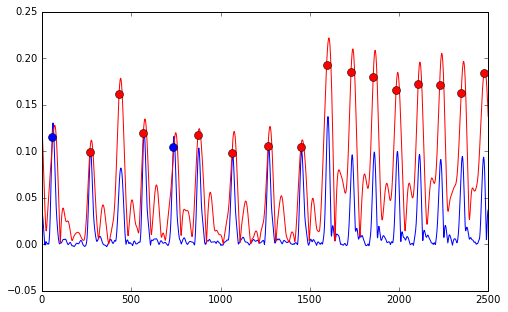

v626s on channel V with max ventricular HR:  123.287671233
[-1. -1. -1. -1. -3. -3. -3. -3. -1. -1. -1. -1. -1. -1. -1.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


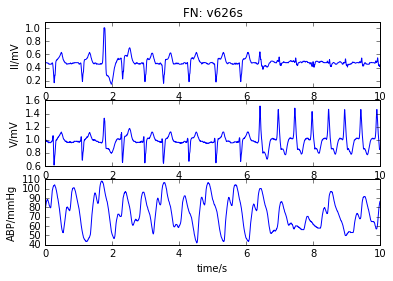

In [34]:
sample_name = "v626s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

Here, even though the overall ventricular HR > 95 bpm for both ECG channels, the ventricular beats are detected in different parts of the signal. The channels' local scores therefore cancel each other out, despite the overall HR being above the threshold. 

#### Irregular signal

No annotations in specified sample range
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


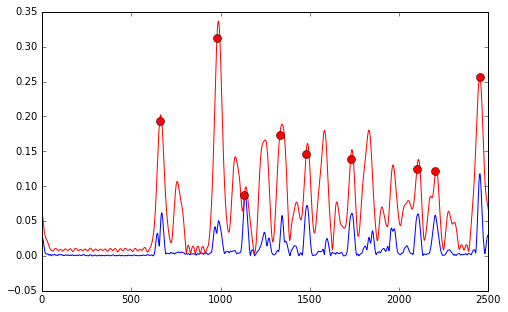

v448s on channel II with max ventricular HR:  90.1803607214
[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


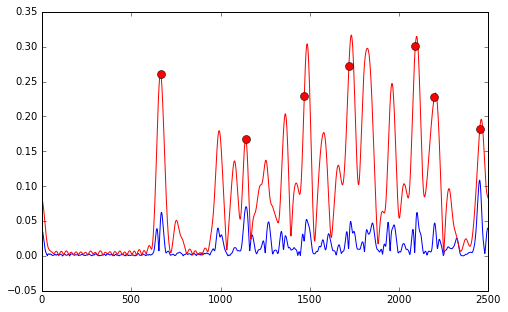

v448s on channel V with max ventricular HR:  61.8131868132


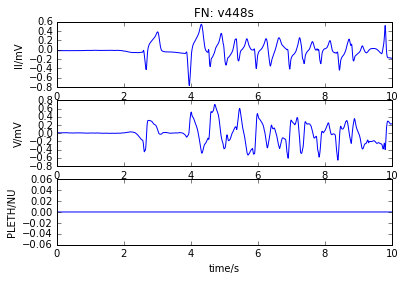

In [35]:
sample_name = "v448s"
classify_and_plot_signal(data_path, ann_path, sample_name, ecg_ann_type, verbose=True)

## Obvious avenues of improvement

1. Improve criteria for selecting "best" channel for bradycardia and tachycardia
2. Fewer beats necessary to detect tachycardia 
3. Better annotations for QRS complexes
4. Ventricular tachycardia detected in one channel can be canceled out by vtach not detected in other channel